# Introducción

## El objetivo del presente trabajo práctico es aplicar los conceptos teóricos y práticos aprendidos de la materia a la predicción de una feature en el dataset de lluvia de hamburguesas y a su vez relatar en el notebook el análisis y procedimiento utilizado para poder generar dicha predicción.

In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport

In [2]:
df_1 = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv', low_memory=False
)
df_2 = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv', low_memory=False
)
pd.options.display.max_columns = None

df = df_2.merge(df_1, left_on = 'id', right_on = 'id')
df.sort_values(by=['id'], inplace=True, ascending=True)

df_original = df.copy()

df.sample(10)

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
78285,Palermo cheto,2013-03-18,Sursureste,Este,NaN,20.0,32.0,143899,no,NaN,0.0,NaN,NaN,1012.0,1016.3,Este,35.0,34.9,19.6,33.5,24.4,17.0,26.0,no
4994,Floresta,2009-08-21,Nornoreste,Nornoreste,0.4,88.0,79.0,36761,no,2.4,0.4,7.0,8.0,1002.5,1007.8,Oestesuroeste,48.0,13.2,5.3,12.2,10.7,22.0,9.0,si
74259,Liniers,2008-06-06,Nornoreste,Sureste,9.0,42.0,74.0,45805,no,1.6,0.0,1.0,1.0,1022.1,1025.2,Sur,22.0,16.7,4.4,16.2,9.6,4.0,11.0,no
102387,Villa Real,2011-06-30,Noroeste,Nornoreste,8.3,52.0,74.0,130902,no,0.8,0.0,NaN,NaN,1033.1,1036.0,Nornoreste,41.0,14.0,3.8,13.8,6.5,17.0,11.0,no
80691,Balvanera,2016-12-01,Oestenoroeste,Norte,NaN,NaN,NaN,8851,no,NaN,0.0,NaN,NaN,1004.4,1006.7,Oestenoroeste,48.0,36.2,17.9,35.2,28.1,24.0,19.0,no
180,Nueva Pompeya,2015-12-16,Sureste,Sureste,NaN,12.0,34.0,60624,no,NaN,0.0,NaN,NaN,1012.2,1014.7,Sur,48.0,34.3,14.1,32.1,24.9,9.0,17.0,no
5284,Parque Avellaneda,2010-03-31,Oestesuroeste,suroeste,7.6,48.0,78.0,67838,no,3.6,0.0,1.0,7.0,1019.9,1023.0,suroeste,26.0,23.9,13.4,23.4,13.8,9.0,7.0,no
49065,Monte Castro,2014-06-04,Oestesuroeste,Nornoreste,NaN,98.0,97.0,53984,si,NaN,1.2,NaN,NaN,NaN,NaN,suroeste,33.0,8.7,1.0,5.3,6.1,6.0,2.0,no
24692,Saavedra,2015-10-03,Sureste,Sureste,NaN,55.0,91.0,89608,no,NaN,1.0,8.0,8.0,1021.0,1023.8,Sureste,59.0,28.4,20.6,25.9,21.4,39.0,26.0,si
65879,San Telmo,2016-08-13,Oestenoroeste,Norte,NaN,56.0,96.0,99196,no,NaN,0.0,NaN,NaN,1024.9,1025.7,Oestenoroeste,30.0,15.8,7.9,15.3,10.2,11.0,4.0,no


# Feature engineering
### Buscamos filas duplicadas
### Consideramos a una fila duplicada unicamente cuando se repite el ID de la medicion

In [3]:
df[df.duplicated(subset=['id'],keep=False)]

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,mm_lluvia_dia,nubosidad_tarde,nubosidad_temprano,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente


### Vemos que no hay duplicados, pero verifiquemos además que el tipo para cada feature es razonable:

In [4]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

#### Sabiendo que el pandas trata los strings como 'object', inmediatamente notamos que hay una feature que debería estar marcada como float pero se está tratando como un object: presion_atmosferica_tarde. Por dicho motivo procedemos a transformarla a numérica:

Si hacemos directamente to_numeric(), vemos que encuentra un valor que no puede convertir por tener dos simbolos '.' de decimal, por lo que asumimos que fue un error
al cargar el dato de presion_atmosferica_tarde, y preferimos dejar ese casillero en NaN que eliminar el registro completo:

In [5]:
df['presion_atmosferica_tarde'].replace('.+\..+\..+', np.nan, inplace=True, regex=True)
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'])

## Variables __categoricas__
1. Barrio 
2. direccion_viento_tarde
3. direccion_viento_temprano
4. rafaga_viento_max_direccion
5. llovieron_hamburguesas_hoy

### Comenzamos por reemplazar los valores nulos en direcciones de viento y ráfagas por una nueva opcion que puede tomar la feature : "Otra direccion"

In [6]:
df['direccion_viento_tarde'].replace(np.nan, 'Otra direccion', inplace=True)
df['direccion_viento_temprano'].replace(np.nan, 'Otra direccion', inplace=True)
df['rafaga_viento_max_direccion'].replace(np.nan, 'Otra direccion',inplace=True)

### Luego verificamos que ninguna feature categorica tenga valores repetidos o sin sentido por errores de tipado 

In [7]:
df.barrio.value_counts().to_frame()

,barrio
Liniers,2737
Constitución,2657
Villa Soldati,2611
Retiro,2580
Villa Luro,2578
Villa Real,2561
Parque Avellaneda,2526
San Telmo,2518
San Nicolás,2482
Saavedra,2464


In [8]:
df.direccion_viento_temprano.value_counts().to_frame()

,direccion_viento_temprano
Nornoreste,12784
Norte,9453
Otra direccion,8403
Sureste,7437
Este,7391
Sursureste,7244
Noroeste,7003
Sur,6948
suroeste,6785
Oeste,6742


In [9]:
df.direccion_viento_tarde.value_counts().to_frame()

,direccion_viento_tarde
Nornoreste,11546
Sureste,8657
Oeste,8053
Sur,7930
Oestesuroeste,7627
Sursureste,7480
suroeste,7477
Norte,7180
Oestenoroeste,7096
Noroeste,6893


In [10]:
df.rafaga_viento_max_direccion.value_counts().to_frame()

,rafaga_viento_max_direccion
Nornoreste,10512
Otra direccion,8269
Oeste,7952
Sureste,7502
Norte,7432
Este,7428
Sursureste,7365
Sur,7314
Oestesuroeste,7227
suroeste,7161


In [11]:
df.llovieron_hamburguesas_hoy.value_counts().to_frame()

,llovieron_hamburguesas_hoy
no,88359
si,25394


#### Vemos que todos los valores son unicos, no hay necesidad de alterar las features y podemos seguir con la conversion a valores numericos

## Variables __numéricas__


### Comenzamos por buscar cuáles columnas tienen missings

In [12]:
df.fillna(np.nan, inplace = True)
df_nulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum(), 'Porcentaje de nulos': (df.isnull().mean() * 100)})
df_nulos.sort_values(by=['Porcentaje de nulos'])

,Cantidad de nulos,Porcentaje de nulos
barrio,0,0.000000
dia,0,0.000000
direccion_viento_tarde,0,0.000000
direccion_viento_temprano,0,0.000000
id,0,0.000000
rafaga_viento_max_direccion,0,0.000000
temp_max,1003,0.861921
temp_min,1187,1.020040
temperatura_temprano,1410,1.211673
velocidad_viendo_temprano,1413,1.214251


Vemos que algunos de los features tienen menos de un 1.5% de NaNs, por lo cual usar la media para rellenarlos no implicaría una disonancia significativa en la información, sinó más bien un suavizado de esos casos vacíos.

In [13]:
df['temp_max'].replace(np.nan, df['temp_max'].mean(), inplace = True)
df['temp_min'].replace(np.nan, df['temp_min'].mean(), inplace = True)
df['temperatura_temprano'].replace(np.nan, df['temperatura_temprano'].mean(), inplace = True)
df['velocidad_viendo_temprano'].replace(np.nan, df['velocidad_viendo_temprano'].mean(), inplace = True)

df_nulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum(), 'Porcentaje de nulos': (df.isnull().mean() * 100)})
df_nulos.sort_values(by=['Porcentaje de nulos'])

,Cantidad de nulos,Porcentaje de nulos
barrio,0,0.000000
dia,0,0.000000
direccion_viento_tarde,0,0.000000
direccion_viento_temprano,0,0.000000
temperatura_temprano,0,0.000000
id,0,0.000000
temp_min,0,0.000000
velocidad_viendo_temprano,0,0.000000
temp_max,0,0.000000
rafaga_viento_max_direccion,0,0.000000


Para las features con alta cardinalidad de nulos (horas_de_sol, nubosidad_temprano, nubosidad_tarde) analizaremos cada caso en particular para observar la relacion de dichos nulos con la variable target. 
Desconocemos como se computa la nubosidad, y por eso no podemos afirmar que se trata de columnas con missings at random (MAR)}. Es decir, no podemos afirmar que la falta de informacion en nubosidad dependa de horas_de_sol, (lo mismo aplica para nubosidad_temprano y nubosidad_tarde), por ende trataremos estos missings como MCAR completely at random.

# Formulación de Preguntas y Visualización
## Primero nos hacemos una serie de preguntas para comprender y analizar mejor nuestros datos:  

 1. ¿Suponiendo desconocimiento de todas las features excepto el target, que tan probable es que lluevan hamburguesas al dia siguiente?
 2. ¿De qué manera se relaciona el barrio con que lluevan hamburguesas al dia siguiente?
 3. ¿Si llovieron hamburguesas hoy, qué tan probable es que lluevan hamburguesas mañana?
 4. ¿Cómo afecta la feature mm_lluvia_dia al target? ¿Y qué sucede con los mm evaporados?
 5. ¿Hay correlación entre la feature horas_de_sol y la lluvia de hamburguesas del dia siguiente?
 6. ¿Cómo se relacionan la nubosidad_temprano y la nubosidad_tarde con el target?
 7. ¿Las direcciones del viento temprano y tarde, estarán involucradas en la búsqueda del baseline?
 8. ¿Cómo afectan las velocidades de los vientos tempranos y tardes al baseline?
 9. ¿En cuánto al viento, las ráfagas tienen efecto en el target?
 10. ¿Los máximos y mínimos de temperatura, indican algo sobre si llueven o no hamburguesas al dia siguiente?
 11. ¿Tiene relación la humedad con la variable target?
 12. ¿Es observable una correlación entre la presión atmosférica y el target?
 13. ¿Son de utilidad las mediciones donde el target tiene el valor NaN?
 
Buscamos entender cada uno de los datos, cómo se relacionan entre sí y ver que conclusiones podemos obtener. A partir de ellos vamos a determinar los factores que determinan si lloverá al dia siguiente, y verificaremos cuáles features son reelevantes de mantener en el dataset.

### 1.¿Suponiendo desconocimiento de todas las features excepto el target, que tan probable es que lluevan hamburguesas al dia siguiente?

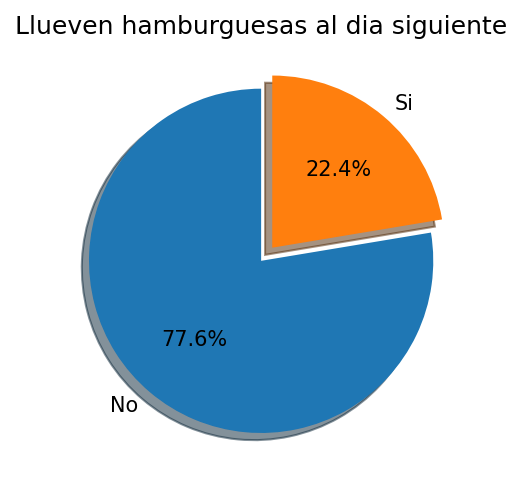

In [14]:
plt.figure(figsize=(5.4, 3.8), dpi=150)
labels = ['No', 'Si']
sizes = df['llovieron_hamburguesas_al_dia_siguiente'].value_counts()
explode = (0, 0.1)
plt.title('Llueven hamburguesas al dia siguiente')
plt.pie(sizes, explode=explode, data = df['llovieron_hamburguesas_al_dia_siguiente'],labels = labels ,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

Podemos corroborar, que desconociendo el resto de features, para el 77.6% de los registros en el dataset al dia siguiente no llueven hamburguesas. Esto quiere decir que si armaramos una baseline que simplemente devuelva siempre "NO", el accuracy ya sería de ese porcentaje. Sin embargo, no solo es un accuracy que no nos satisface, sinó que resulta en algo poco reutilizable que desperdicia el resto de información.

### 2. ¿De qué manera se relaciona el barrio con que lluevan hamburguesas al dia siguiente?

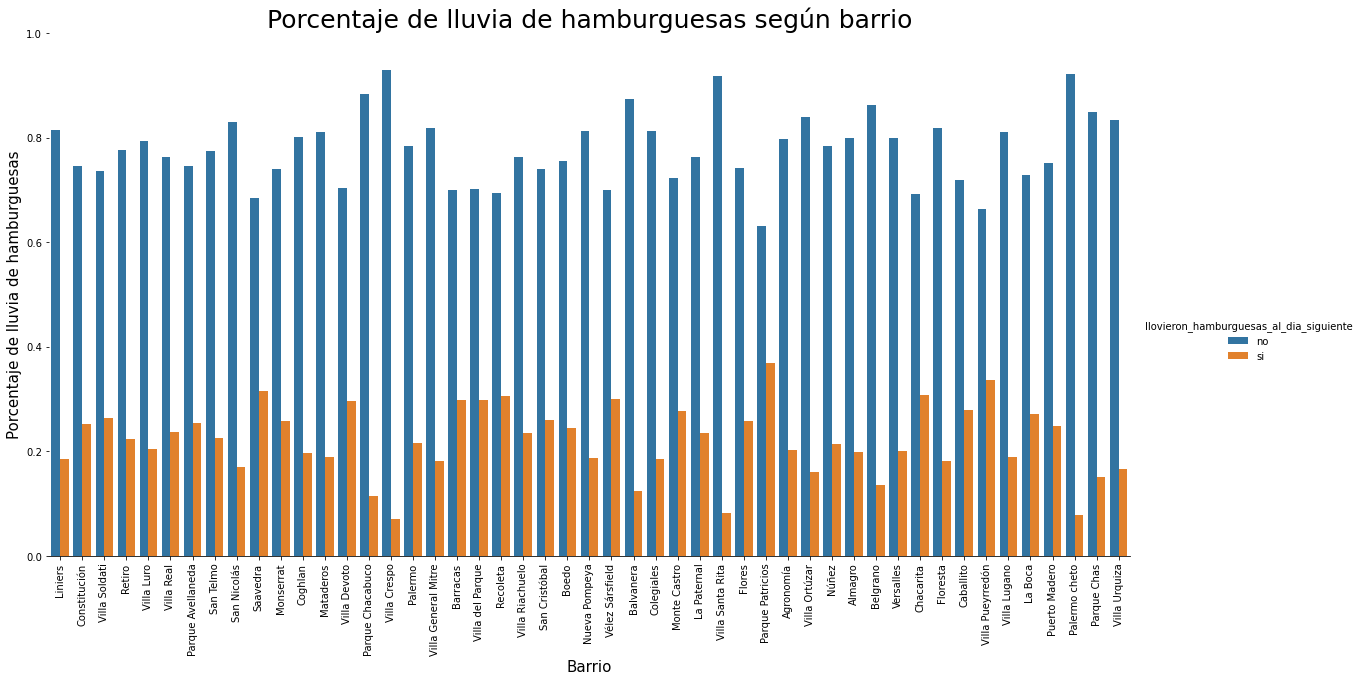

In [15]:
lluvurguesas_por_barrio = df.groupby(by="barrio")['llovieron_hamburguesas_al_dia_siguiente'].value_counts(normalize=True)
lluvurguesas_por_barrio = lluvurguesas_por_barrio.to_frame()
lluvurguesas_por_barrio.rename(columns={'llovieron_hamburguesas_al_dia_siguiente':'porcentaje_por_barrio'},inplace=True)
lluvurguesas_por_barrio.reset_index(inplace=True)

g = sns.catplot(
    data=lluvurguesas_por_barrio, kind="bar",
    x="barrio", y="porcentaje_por_barrio", hue="llovieron_hamburguesas_al_dia_siguiente", order=df["barrio"].value_counts().index,
    ci=None, height=8,aspect=2
)
plt.title("Porcentaje de lluvia de hamburguesas según barrio", fontsize=25)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Barrio", "Porcentaje de lluvia de hamburguesas",  fontsize=15)
plt.show()

Podemos ver que en ningún barrio es predominante el "SI" para la feature llovieron_hamburguesas_al_dia_siguiente, por lo que no podemos hacer ninguna afirmación positiva para la lluvia de hamburguesas según el barrio. Sin embargo, podemos notar que ciertos barrios como Parque Patricios y Villa Pueryrredón, tienen lluvia de hamburguesas al dia siguiente más seguido de lo normal (un \~30% de las veces), mientras que barrios como Villa Crespo y Villa Santa Rita rondan números mas bajos (\~10%).

### 3.¿Si llovieron hamburguesas hoy, qué tan probable es que lluevan hamburguesas mañana?

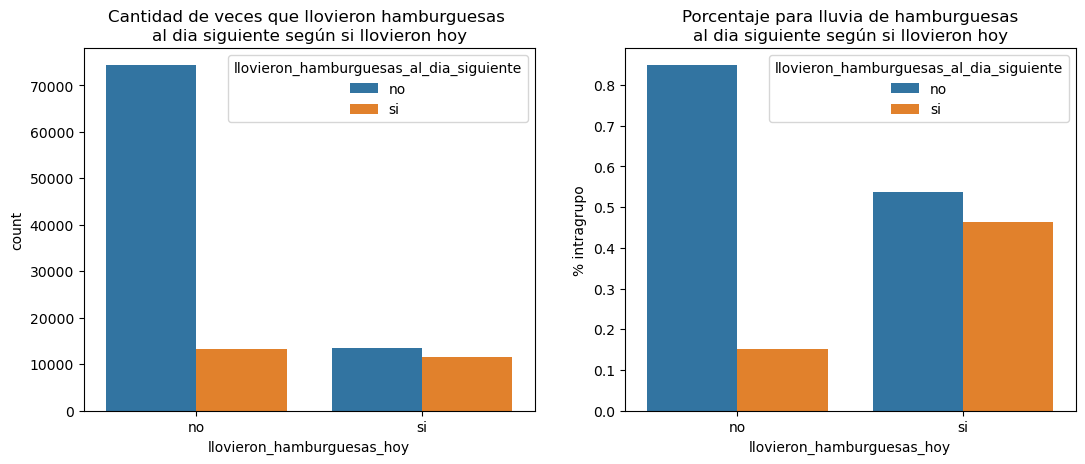

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

sns.countplot(data=df, x='llovieron_hamburguesas_hoy', hue='llovieron_hamburguesas_al_dia_siguiente', ax=axes[0])
axes[0].set_title("Cantidad de veces que llovieron hamburguesas \n" +  "al dia siguiente según si llovieron hoy")

sns.barplot(
    data=df.groupby("llovieron_hamburguesas_hoy")
    .llovieron_hamburguesas_al_dia_siguiente.value_counts(normalize=True)
    .rename("llovieron_al_dia_siguiente_prop")
    .reset_index(),
    x='llovieron_hamburguesas_hoy',
    y="llovieron_al_dia_siguiente_prop",
    hue='llovieron_hamburguesas_al_dia_siguiente',
    ax=axes[1],
)
axes[1].set_ylabel("% intragrupo")
axes[1].set_title("Porcentaje para lluvia de hamburguesas\n" +  "al dia siguiente según si llovieron hoy")

plt.show()

Podemos ver que si bien la cantidad de veces que llueven hamburguesas al dia siguiente es prácticamente la misma en ambas mitades del primer gráfico,cuando lo analizamos en porcentajes, vemos que si llovio el dia de hoy, la probabilidad de que lluevan hamburguesas al dia siguiente aumenta radicalmente. Concluimos de esta visualización, que si llovieron hamburguesas hoy, hay practicamente un 45% de probabilidades que llueva mañana, mientras que si hoy no llovieron hamburguesas, entonces esa probabilidad es mucho menor, de aproximadamente el 15%

### 4.¿Cómo afecta la feature mm_lluvia_dia al target? ¿Y qué sucede con los mm evaporados?

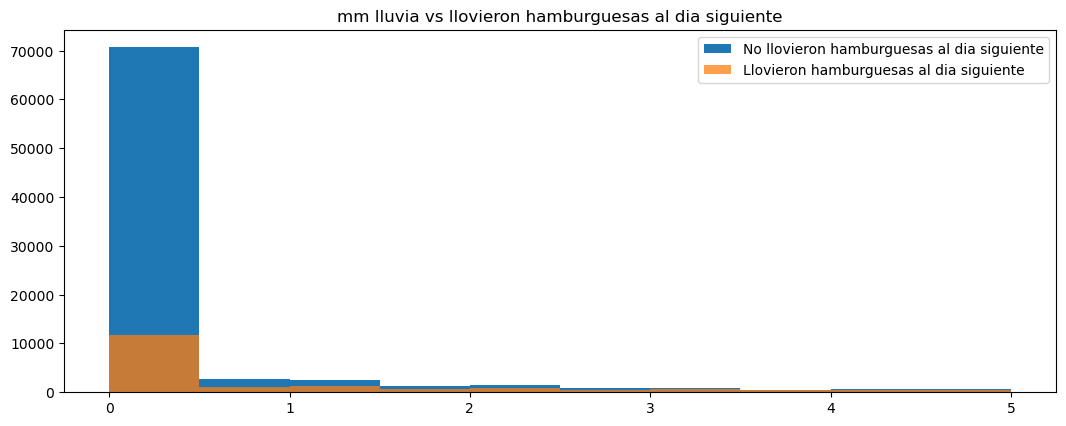

In [17]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

plt.hist(df_no_llovio_h_maniana.mm_lluvia_dia, alpha=1, range=[0, 5], label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.mm_lluvia_dia, alpha=0.75, range=[0, 5], label='Llovieron hamburguesas al dia siguiente')
plt.legend()
plt.title('mm lluvia vs llovieron hamburguesas al dia siguiente')
plt.show()


Se puede observar que si tomamos en cuenta las distintas escalas del eje de las ordenadas (cantidad de dias donde llovieron o no hamburguesas), entonces la distribución de los mm de lluvia es muy similar en ambas, por lo que no nos llevaria a ninguna estimación concluyente del target. Veamos si para los mm evaporados de agua en el dia obtenemos una distribución mejor indicadora del target:

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


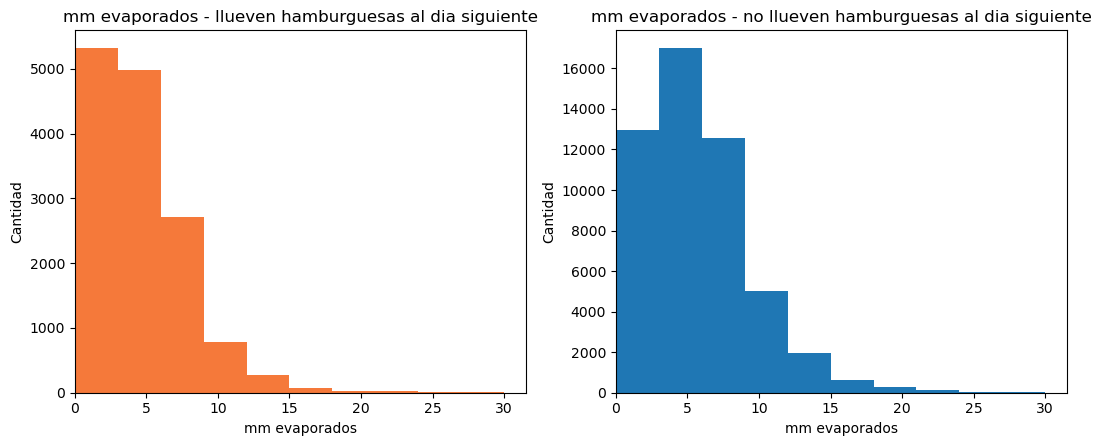

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.mm_evaporados_agua.plot(kind='hist', ax=axes[0], xlim=0, color='#f5793a', range = [0,30])
axes[0].set_title("mm evaporados - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("mm evaporados")

df_no_llovio_h_maniana.mm_evaporados_agua.plot(kind='hist', ax=axes[1], xlim=0, range = [0,30])
axes[1].set_title("mm evaporados - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("mm evaporados")
plt.show()

Unificando ambos histogramas en un mismo par de ejes cartesianos:

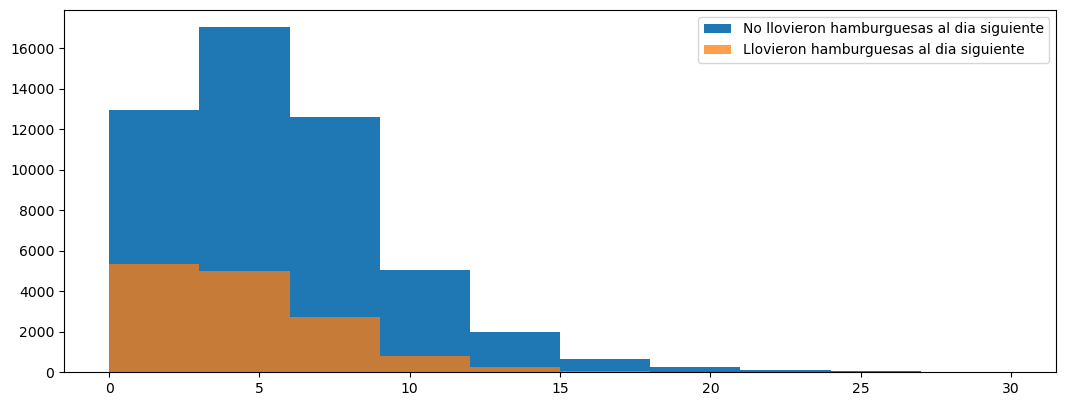

In [19]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

plt.hist(df_no_llovio_h_maniana.mm_evaporados_agua, alpha=1, range=[0, 30], label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.mm_evaporados_agua, alpha=0.75, range=[0, 30], label='Llovieron hamburguesas al dia siguiente')
plt.legend()
plt.show()

Podemos observar que las distribuciones en la visualización vuelven a ser  similares tanto para el valor afirmativo del target como en caso contrario, por lo que a priori los mm_evaporados no parecen ser un gran indicador para predecir el mismo. Para considerar una relación con la variable target deberiamos apreciar diferencias más significativas.

### 5.¿Hay correlación entre la feature horas_de_sol y la lluvia de hamburguesas del dia siguiente?


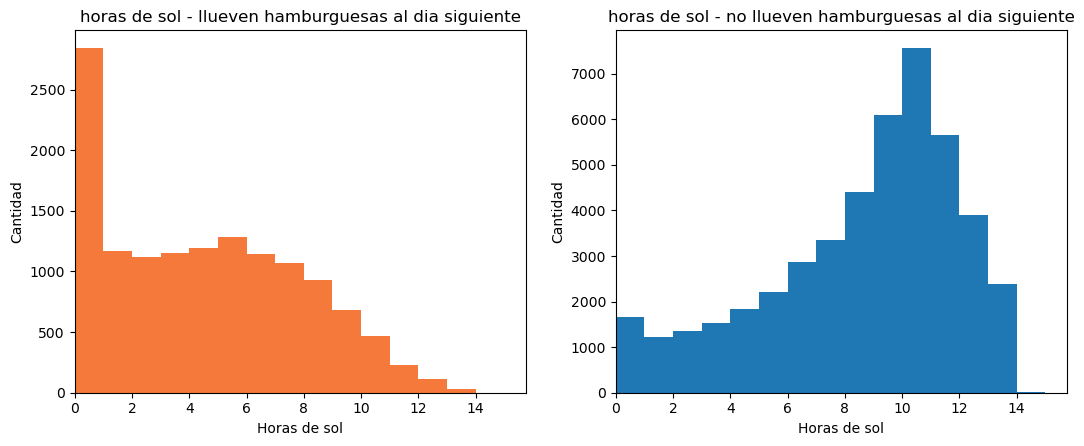

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.horas_de_sol.plot(kind='hist', bins=15, range=[0, 15], ax=axes[0], xlim=0,color='#f5793a')
axes[0].set_title("horas de sol - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Horas de sol")

df_no_llovio_h_maniana.horas_de_sol.plot(kind='hist', bins=15, range=[0,15], ax=axes[1], xlim=0)
axes[1].set_title("horas de sol - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Horas de sol")
plt.show()


Unificando ambos histogramas en el mismo par de ejes cartesianos:


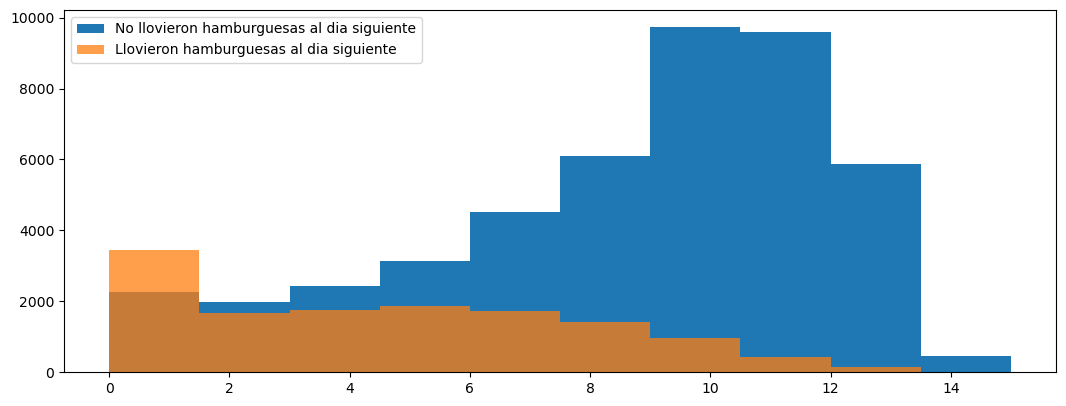

In [21]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

plt.hist(df_no_llovio_h_maniana.horas_de_sol, range=[0,15], label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.horas_de_sol, alpha=0.75, range=[0,15], label='Llovieron hamburguesas al dia siguiente')

plt.legend()
plt.show()

Comparando ámbos gráficos, vemos grandes diferencias en las distribuciones de las horas de sol según el valor del target. Cuando al día siguiente llueven hamburguesas, el gráfico de la izquierda nos indica que suele haber en general pocas horas de sol. Caso contrario, en el gráfico de la derecha vemos que la mayoría de dias en los cuales no llueven hamburguesas al día siguiente se agrupan a partir de aproximadamente 8 horas de sol.

Sin embargo, debemos analizar que sucede cuando horas de sol tiene missings. Dado que es una feature con una cardinalidad muy grande de valores nulos, amerita un analisis en detalle.

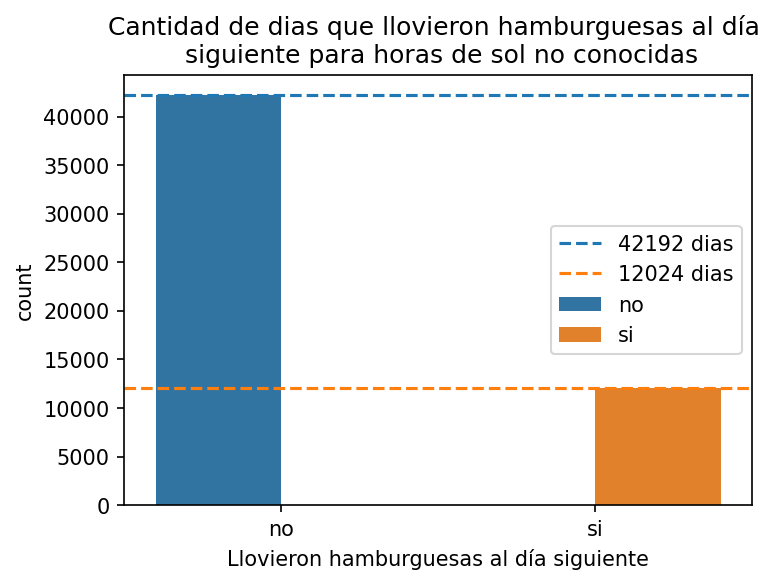

In [22]:
fig =  plt.figure(figsize=(5.4, 3.8), dpi=150)\

df_horas_sol_desconocidas = df[(df['horas_de_sol'].isna())]

total_dias_lluvia = sum(df_horas_sol_desconocidas.llovieron_hamburguesas_al_dia_siguiente == 'si')
total_dias_sin_lluvia = sum(df_horas_sol_desconocidas.llovieron_hamburguesas_al_dia_siguiente == 'no')

sns.countplot(data=df_horas_sol_desconocidas, x='llovieron_hamburguesas_al_dia_siguiente', hue='llovieron_hamburguesas_al_dia_siguiente')
plt.title("Cantidad de dias que llovieron hamburguesas al día \n siguiente para horas de sol no conocidas")
plt.xlabel("Llovieron hamburguesas al día siguiente")
plt.axhline(y=total_dias_sin_lluvia, color="C0", label=f"{total_dias_sin_lluvia} dias", linestyle='--')
plt.axhline(y=total_dias_lluvia, color="C1", label=f"{total_dias_lluvia} dias",  linestyle='--')
plt.legend(loc='best')
plt.show()

Del grafico de barras vemos que aproximadamente el 80% de los casos en los que no conocemos las horas de sol, tampoco llovieron hamburguesas al dia siguiente. Este dato podría ser tenido en cuenta a la hora de definir que decisión deberia tomar nuestra baseline.

### 6. ¿Cómo se relacionan la nubosidad_temprano y la nubosidad_tarde con el target?



C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


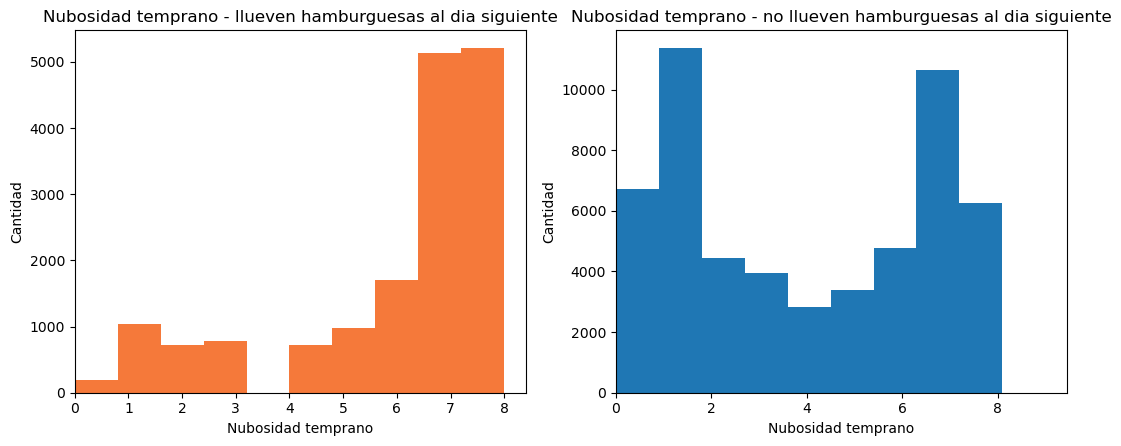

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']


df_llovio_h_maniana.nubosidad_temprano.plot(kind='hist', ax=axes[0], xlim=0, color='#f5793a', bins=10)
axes[0].set_title("Nubosidad temprano - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Nubosidad temprano")

df_no_llovio_h_maniana.nubosidad_temprano.plot(kind='hist', ax=axes[1], xlim=0, bins=10)
axes[1].set_title("Nubosidad temprano - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Nubosidad temprano")
plt.show()


Unificando ambos histogramas en el mismo par de ejes cartesianos:

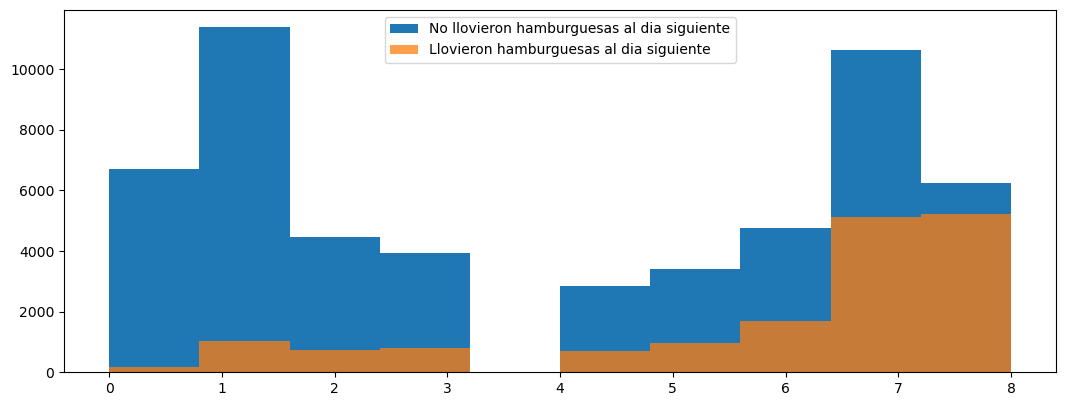

In [24]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']
rango_nubosidad_temp = [0,8]

plt.hist(df_no_llovio_h_maniana.nubosidad_temprano, range=rango_nubosidad_temp, label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.nubosidad_temprano, alpha=0.75, range=rango_nubosidad_temp, label='Llovieron hamburguesas al dia siguiente')

plt.legend()
plt.show()
#Chequear espacio vacio entre 3 y 4, para no llovieron deberia haber algunos casos. Con range de 0 a 9 no aparece

Vemos que la distribución en ambos gráficos es muy diferente, por lo que parece interesante considerar los dias de alta nubosidad temprana en búsqueda de predecir target. Pasemos a analizar la nubosidad a la tarde:

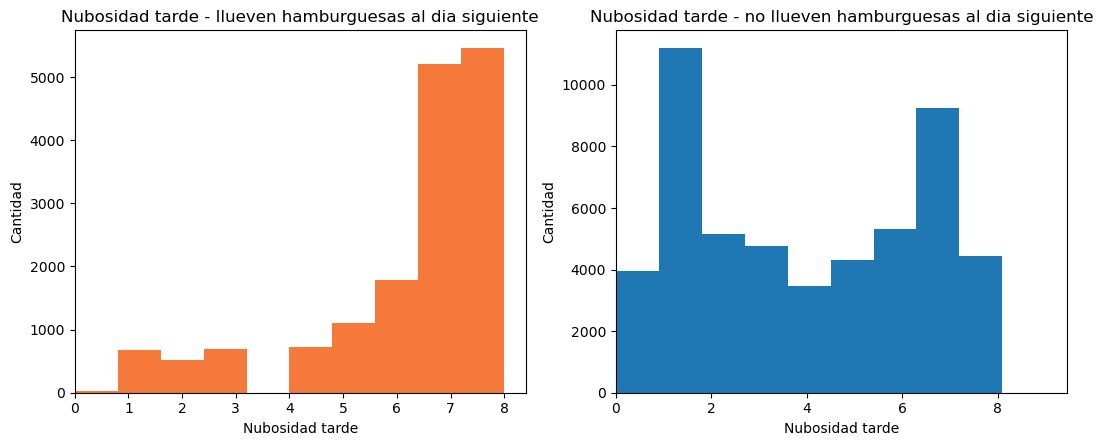

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.nubosidad_tarde.plot(kind='hist', ax=axes[0], xlim=0,color='#f5793a', bins=10)
axes[0].set_title("Nubosidad tarde - llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Nubosidad tarde")

df_no_llovio_h_maniana.nubosidad_tarde.plot(kind='hist', ax=axes[1], xlim=0, bins=10)
axes[1].set_title("Nubosidad tarde - no llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Nubosidad tarde")
plt.show()


Unificando ambos histogramas bajo el mismo par de ejes cartesianos:


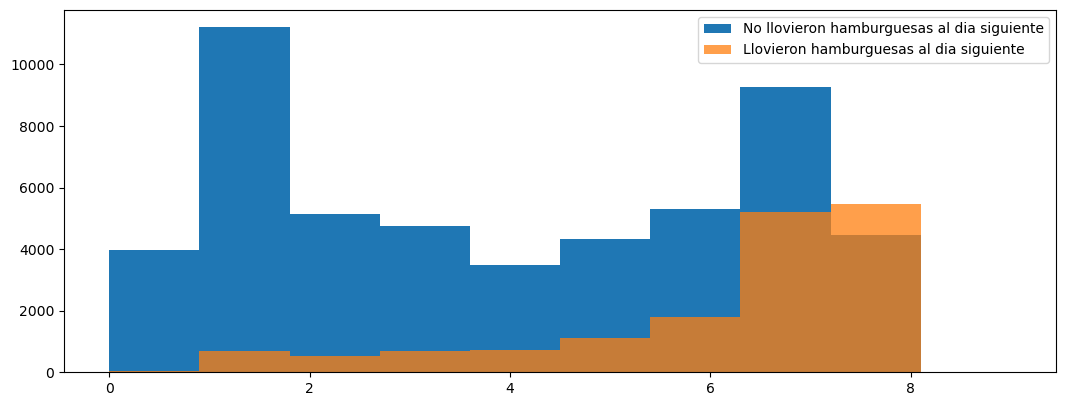

In [26]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']
rango_nubosidad_tarde = [0,9]

plt.hist(df_no_llovio_h_maniana.nubosidad_tarde, range=rango_nubosidad_tarde, label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.nubosidad_tarde,alpha=0.75, range=rango_nubosidad_tarde, label='Llovieron hamburguesas al dia siguiente')

plt.legend()
plt.show()

Para la nubosidad a la tarde, la visualización resulta muy similar al caso de la nubosidad temprana, tanto para cuando llueven hamburguesas al dia siguiente como cuando no lo hace.

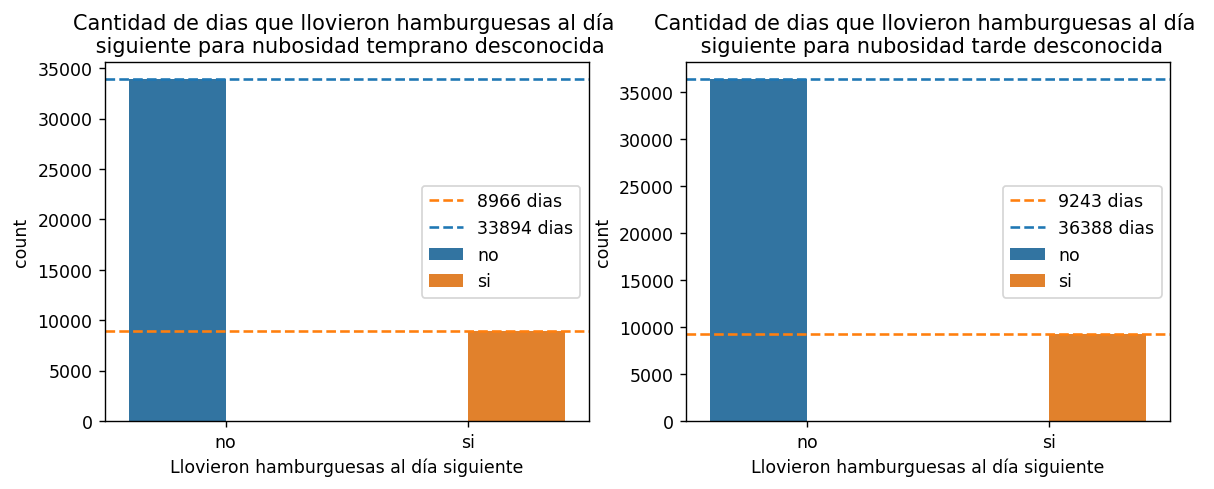

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3.8), dpi=125)

df_nubosidad_temprana_desconocida = df[(df['nubosidad_temprano'].isna())]
total_dias_lluvia_nubosidad_temprana_desc = sum(df_nubosidad_temprana_desconocida.llovieron_hamburguesas_al_dia_siguiente == 'si')
total_dias_sin_lluvia_nubosidad_temprana_desc = sum(df_nubosidad_temprana_desconocida.llovieron_hamburguesas_al_dia_siguiente == 'no')

sns.countplot(data=df_nubosidad_temprana_desconocida, x='llovieron_hamburguesas_al_dia_siguiente', hue='llovieron_hamburguesas_al_dia_siguiente', ax=axes[0])
axes[0].set_title("Cantidad de dias que llovieron hamburguesas al día \n siguiente para nubosidad temprano desconocida")
axes[0].set_xlabel("Llovieron hamburguesas al día siguiente")
axes[0].axhline(y=total_dias_lluvia_nubosidad_temprana_desc, color="C1", label=f"{total_dias_lluvia_nubosidad_temprana_desc} dias",  linestyle='--')
axes[0].axhline(y=total_dias_sin_lluvia_nubosidad_temprana_desc, color="C0", label=f"{total_dias_sin_lluvia_nubosidad_temprana_desc} dias", linestyle='--')
axes[0].legend(loc='best')

df_nubosidad_tarde_desconocida = df[(df['nubosidad_tarde'].isna())]
total_dias_lluvia_nubosidad_tarde_desc = sum(df_nubosidad_tarde_desconocida.llovieron_hamburguesas_al_dia_siguiente == 'si')
total_dias_sin_lluvia_nubosidad_tarde_desc = sum(df_nubosidad_tarde_desconocida.llovieron_hamburguesas_al_dia_siguiente == 'no')

sns.countplot(data=df_nubosidad_tarde_desconocida, x='llovieron_hamburguesas_al_dia_siguiente', hue='llovieron_hamburguesas_al_dia_siguiente',ax=axes[1])
axes[1].set_title("Cantidad de dias que llovieron hamburguesas al día \n siguiente para nubosidad tarde desconocida")
axes[1].set_xlabel("Llovieron hamburguesas al día siguiente")
axes[1].axhline(y=total_dias_lluvia_nubosidad_tarde_desc, color="C1", label=f"{total_dias_lluvia_nubosidad_tarde_desc} dias",  linestyle='--')
axes[1].axhline(y=total_dias_sin_lluvia_nubosidad_tarde_desc, color="C0", label=f"{total_dias_sin_lluvia_nubosidad_tarde_desc} dias", linestyle='--')
axes[1].legend(loc='best')

plt.show()

Analogamente al caso de las horas de sol desconocidas, cuando la nubosidad es desconocida (practicamente idéntico para ambas),en el 80% de los casos no llovieron hamburguesas al dia siguiente. También sera tenido en cuenta este dato a la hora de predecir el target


### 7. ¿Las direcciones del viento temprano y tarde, estarán involucradas en la búsqueda del baseline?

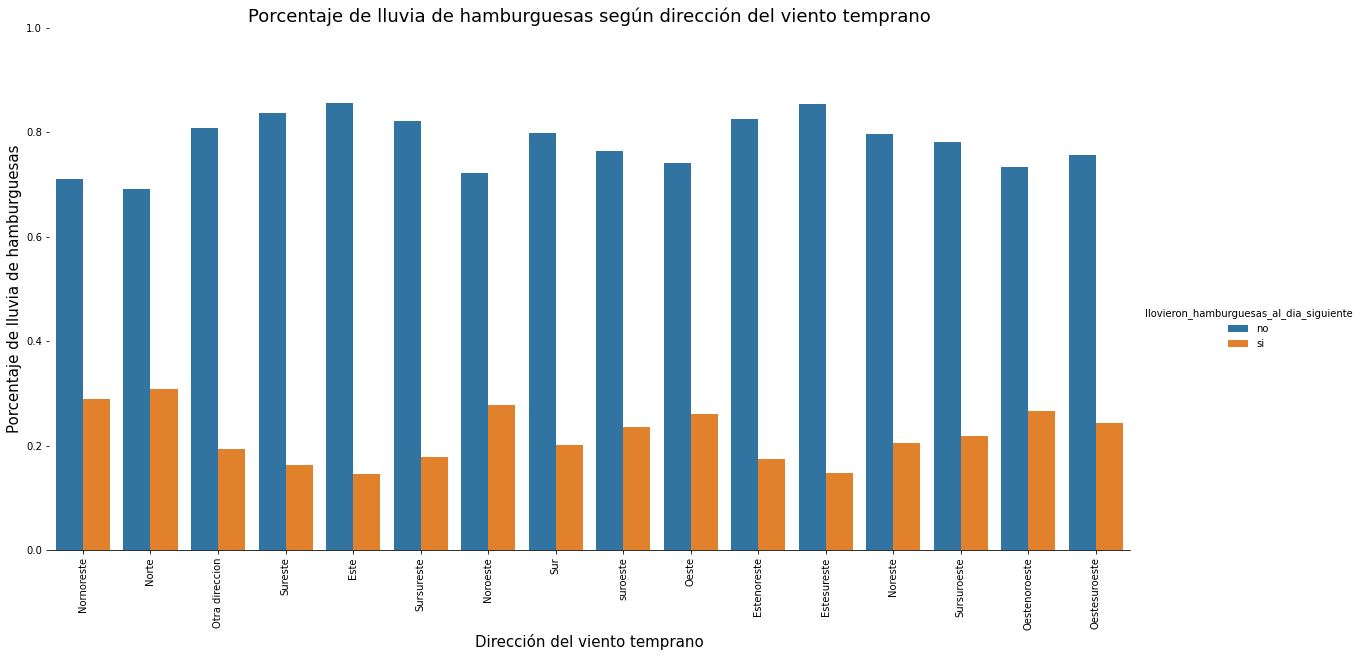

In [28]:
lluvurguesas_viento_temprano = df.groupby(by="direccion_viento_temprano")['llovieron_hamburguesas_al_dia_siguiente'].value_counts(normalize=True)

lluvurguesas_viento_temprano = lluvurguesas_viento_temprano.to_frame()
lluvurguesas_viento_temprano.rename(columns={'llovieron_hamburguesas_al_dia_siguiente':'porcentaje_viento_temprano'},inplace=True)
lluvurguesas_viento_temprano.reset_index(inplace=True)

g = sns.catplot(
    data=lluvurguesas_viento_temprano, kind="bar",
    x="direccion_viento_temprano", y="porcentaje_viento_temprano", hue="llovieron_hamburguesas_al_dia_siguiente", order=df["direccion_viento_temprano"].value_counts().index,
    ci=None, height=8,aspect=2
)
plt.title("Porcentaje de lluvia de hamburguesas según dirección del viento temprano", fontsize=18)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Dirección del viento temprano", "Porcentaje de lluvia de hamburguesas",  fontsize=15)
plt.show()

No parece que la dirección del viento temprano tenga una influencia tajante en el comportamiento del target. Vemos que todas las direcciones tienen la mayoría rotunda de no llover hamburguesas al dia siguiente. Probemos ahora qué sucede con la dirección del viento a la tarde.

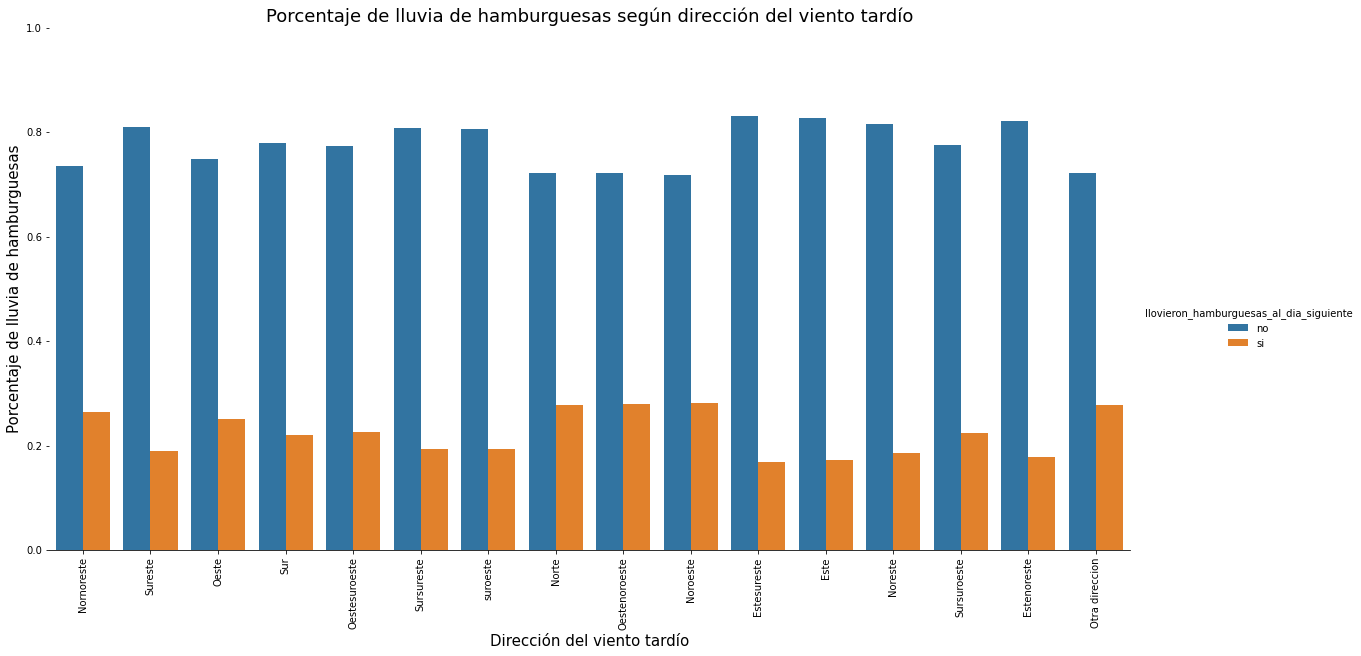

In [29]:
lluvurguesas_viento_tarde = df.groupby(by="direccion_viento_tarde")['llovieron_hamburguesas_al_dia_siguiente'].value_counts(normalize=True)

lluvurguesas_viento_tarde = lluvurguesas_viento_tarde.to_frame()
lluvurguesas_viento_tarde.rename(columns={'llovieron_hamburguesas_al_dia_siguiente':'porcentaje_viento_tarde'},inplace=True)
lluvurguesas_viento_tarde.reset_index(inplace=True)

g = sns.catplot(
    data=lluvurguesas_viento_tarde, kind="bar",
    x="direccion_viento_tarde", y="porcentaje_viento_tarde", hue="llovieron_hamburguesas_al_dia_siguiente", order=df["direccion_viento_tarde"].value_counts().index,
    ci=None, height=8,aspect=2
)
plt.title("Porcentaje de lluvia de hamburguesas según dirección del viento tardío", fontsize=18)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Dirección del viento tardío", "Porcentaje de lluvia de hamburguesas",  fontsize=15)
plt.show()

Al igual que con el viento temprano, el viento a la tarde no parece tampoco influenciar el target de manera determinante como para volverlo parte de nuestra predicción.

### 8. ¿Cómo afectan las velocidades de los vientos tempranos y tardes al baseline?

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


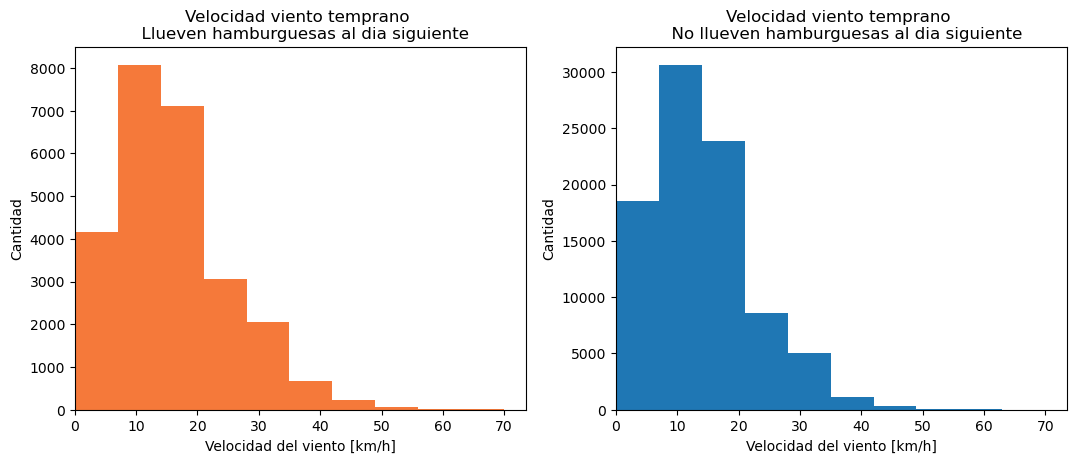

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.velocidad_viendo_temprano.plot(kind='hist', ax=axes[0], xlim=0,range = [0,70], color='#f5793a')
axes[0].set_title("Velocidad viento temprano \n  Llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad del viento [km/h]")

df_no_llovio_h_maniana.velocidad_viendo_temprano.plot(kind='hist', ax=axes[1], xlim=0, range = [0,70])
axes[1].set_title("Velocidad viento temprano \n  No llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad del viento [km/h]")
plt.show()

Unificando ambos histogramas bajo el mismo par de ejes cartesianos:

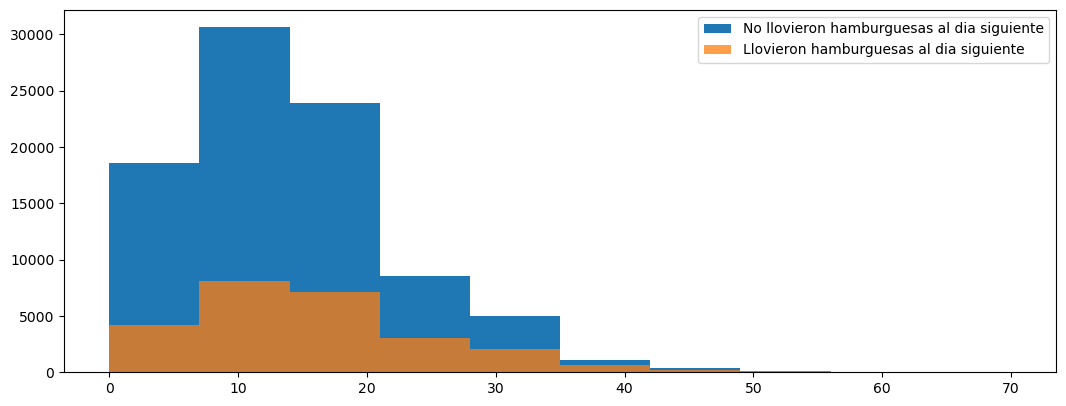

In [31]:
fig = plt.figure( figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']
rango_velocidad_viento_temp = [0,70]

plt.hist(df_no_llovio_h_maniana.velocidad_viendo_temprano,range=rango_velocidad_viento_temp, label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.velocidad_viendo_temprano, alpha=0.75, range=rango_velocidad_viento_temp, label='Llovieron hamburguesas al dia siguiente')
plt.legend()
plt.show()

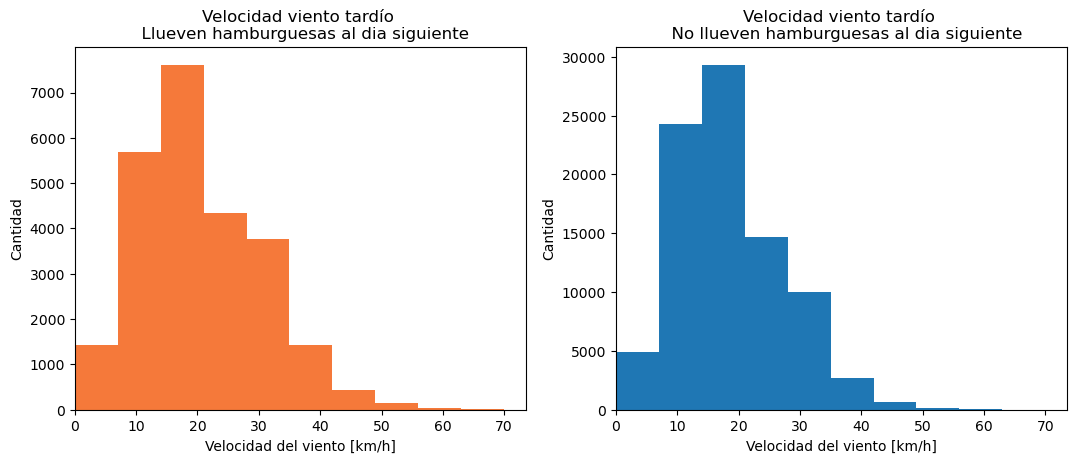

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.velocidad_viendo_tarde.plot(kind='hist', ax=axes[0], xlim=0,range = [0,70], color='#f5793a')
axes[0].set_title("Velocidad viento tardío \n  Llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad del viento [km/h]")

df_no_llovio_h_maniana.velocidad_viendo_tarde.plot(kind='hist', ax=axes[1], xlim=0, range = [0,70])
axes[1].set_title("Velocidad viento tardío \n  No llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad del viento [km/h]")
plt.show()

Unificando ambos histogramas bajo el mismo par de ejes cartesianos:

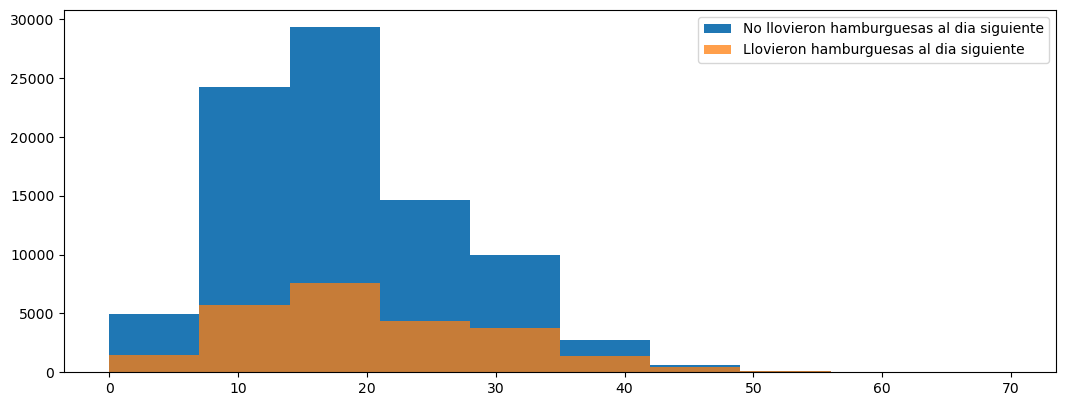

In [33]:
fig = plt.figure( figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']
rango_velocidad_viento_tarde = [0,70]

plt.hist(df_no_llovio_h_maniana.velocidad_viendo_tarde,range=rango_velocidad_viento_temp, label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.velocidad_viendo_tarde, alpha=0.75, range=rango_velocidad_viento_temp, label='Llovieron hamburguesas al dia siguiente')
plt.legend()
plt.show()

Concluimos que la distribución del viento temprano, así como el viento tardío, son prácticamente idénticas lluevan hamburguesas al dia siguiente o no, por lo que no nos servirán para la predicción.

### 9. ¿En cuánto al viento, las ráfagas tienen efecto en el target?

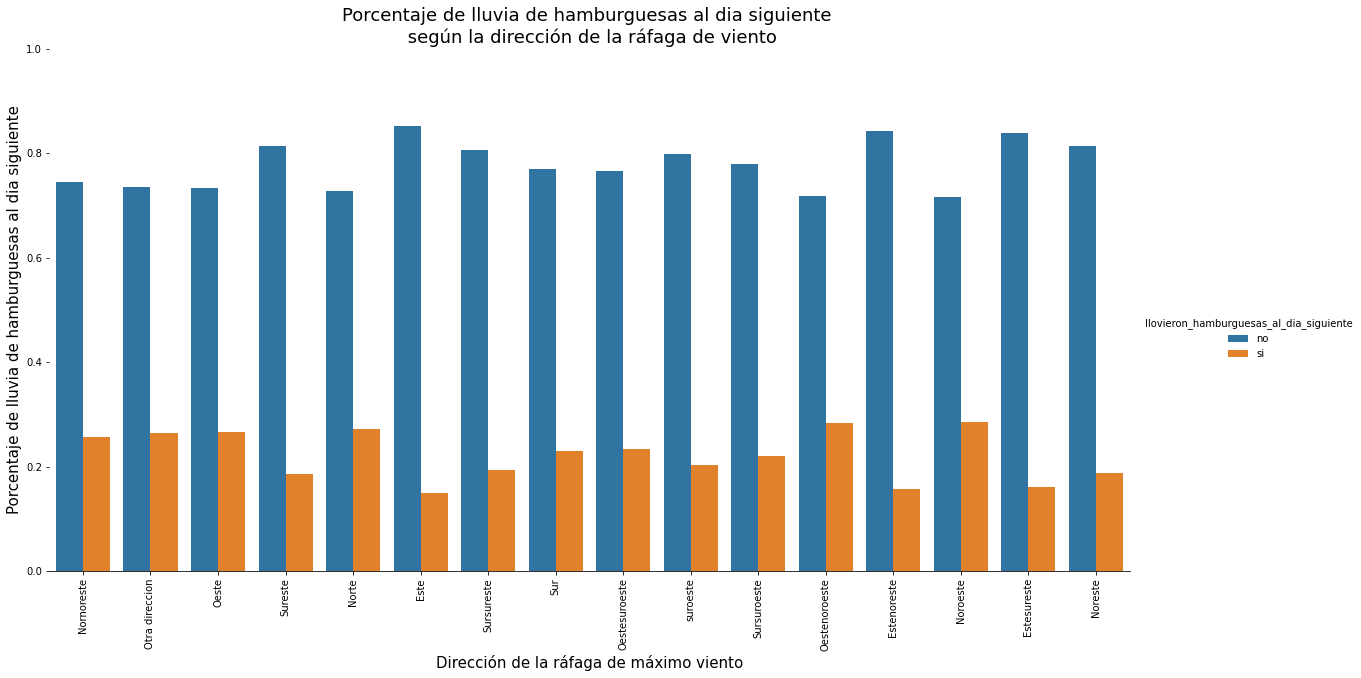

In [34]:
lluvurguesas_dir_rafaga = df.groupby(by="rafaga_viento_max_direccion")['llovieron_hamburguesas_al_dia_siguiente'].value_counts(normalize=True)

lluvurguesas_dir_rafaga = lluvurguesas_dir_rafaga.to_frame()
lluvurguesas_dir_rafaga.rename(columns={'llovieron_hamburguesas_al_dia_siguiente':'porcentaje_dir_rafaga'},inplace=True)
lluvurguesas_dir_rafaga.reset_index(inplace=True)

g = sns.catplot(
    data=lluvurguesas_dir_rafaga, kind="bar",
    x="rafaga_viento_max_direccion", y="porcentaje_dir_rafaga", hue="llovieron_hamburguesas_al_dia_siguiente", order=df["rafaga_viento_max_direccion"].value_counts().index,
    ci=None, height=8,aspect=2
)
plt.title("Porcentaje de lluvia de hamburguesas al dia siguiente \n según la dirección de la ráfaga de viento", fontsize=18)
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("Dirección de la ráfaga de máximo viento", "Porcentaje de lluvia de hamburguesas al dia siguiente",  fontsize=15)
plt.show()

Vemos que al igual que el propio viento, la dirección de su máxima ráfaga no parece tener un distribución divisiva en cuanto al target. ¿Y qué hay de la velocidad de la ráfaga? Vemos a continuación:

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


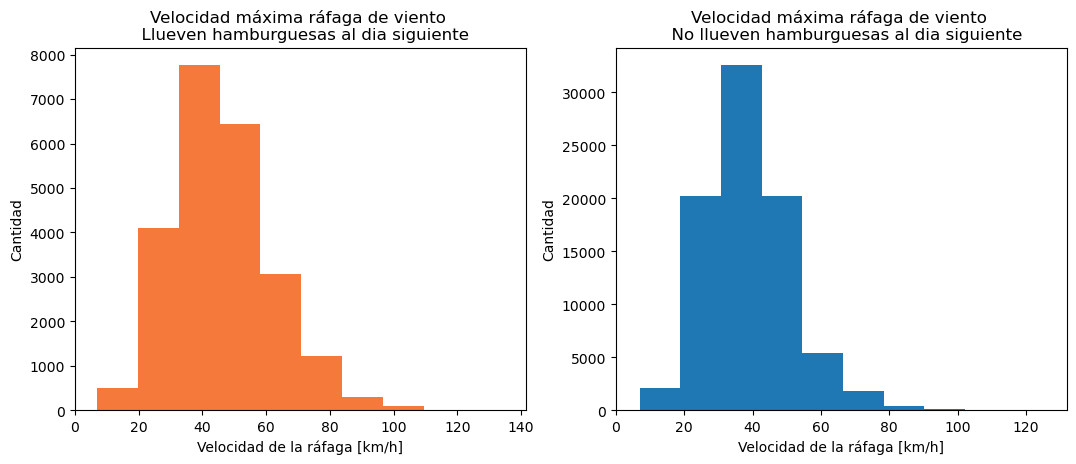

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']

df_llovio_h_maniana.rafaga_viento_max_velocidad.plot(kind='hist', ax=axes[0], xlim=0, color='#f5793a')
axes[0].set_title("Velocidad máxima ráfaga de viento \n  Llueven hamburguesas al dia siguiente")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Velocidad de la ráfaga [km/h]")

df_no_llovio_h_maniana.rafaga_viento_max_velocidad.plot(kind='hist', ax=axes[1], xlim=0)
axes[1].set_title("Velocidad máxima ráfaga de viento \n  No llueven hamburguesas al dia siguiente")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Velocidad de la ráfaga [km/h]")
plt.show()

Unificando ambos histogramas bajo un mismo par de ejes cartesianos:

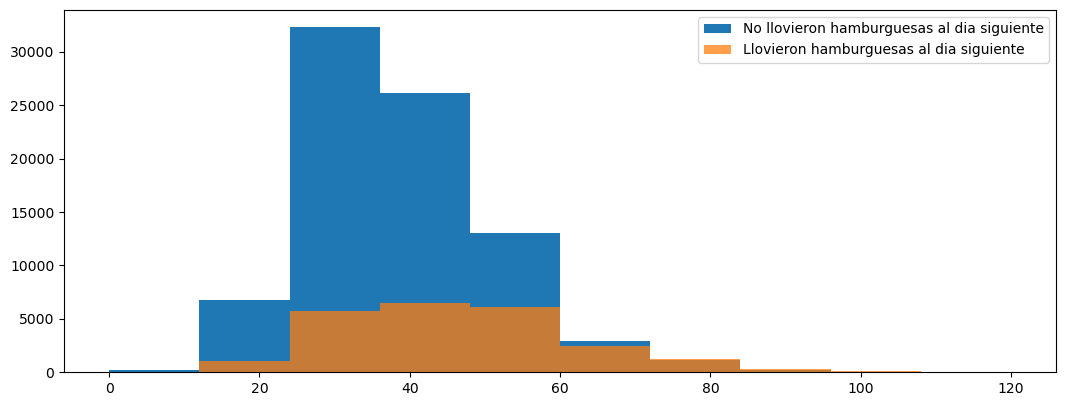

In [36]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'si']
df_no_llovio_h_maniana = df[df.llovieron_hamburguesas_al_dia_siguiente == 'no']
rango_velocidad_rafaga = [0,120]

plt.hist(df_no_llovio_h_maniana.rafaga_viento_max_velocidad,  range=rango_velocidad_rafaga, label='No llovieron hamburguesas al dia siguiente')
plt.hist(df_llovio_h_maniana.rafaga_viento_max_velocidad, alpha=0.75, range=rango_velocidad_rafaga, label='Llovieron hamburguesas al dia siguiente')

plt.legend()
plt.show()

Adicionalmente, vemos que la velocidad de dicha ráfaga tiene también una distribución similar tanto para los casos en los que llueve al dia siguiente como en los que no, por lo que concluimos finalmente que ninguno de los datos respecto al viento nos da información que vayamos a utilizar para discriminar en el baseline.

 ### 10. ¿Los máximos y mínimos de temperatura, indican algo sobre si llueven o no hamburguesas al dia siguiente?

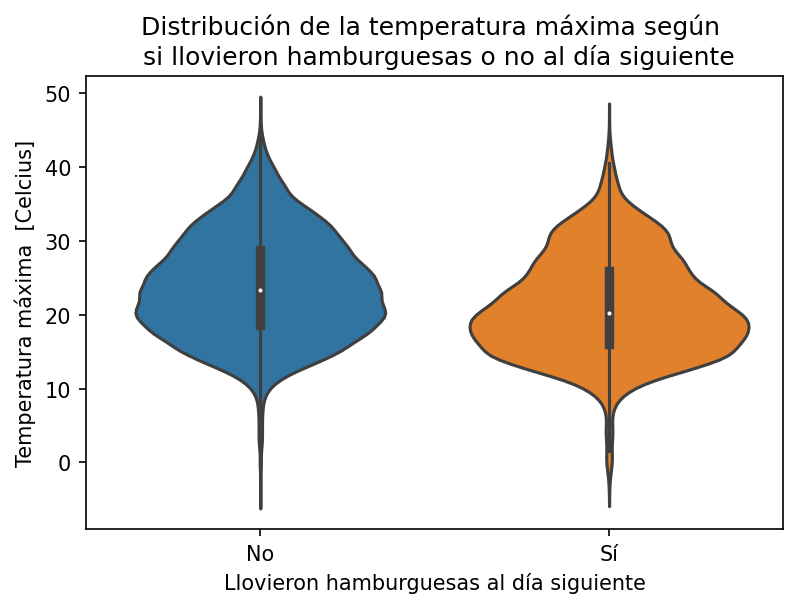

In [37]:
plt.figure(dpi=150)
plt.title("Distribución de la temperatura máxima según \n si llovieron hamburguesas o no al día siguiente")
sns.violinplot(
    data=df,
    y='temp_max',
    x='llovieron_hamburguesas_al_dia_siguiente'
#    palette=['#D17049', "#89D15E"],
)
plt.xlabel("Llovieron hamburguesas al día siguiente")
plt.ylabel("Temperatura máxima  [Celcius]")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

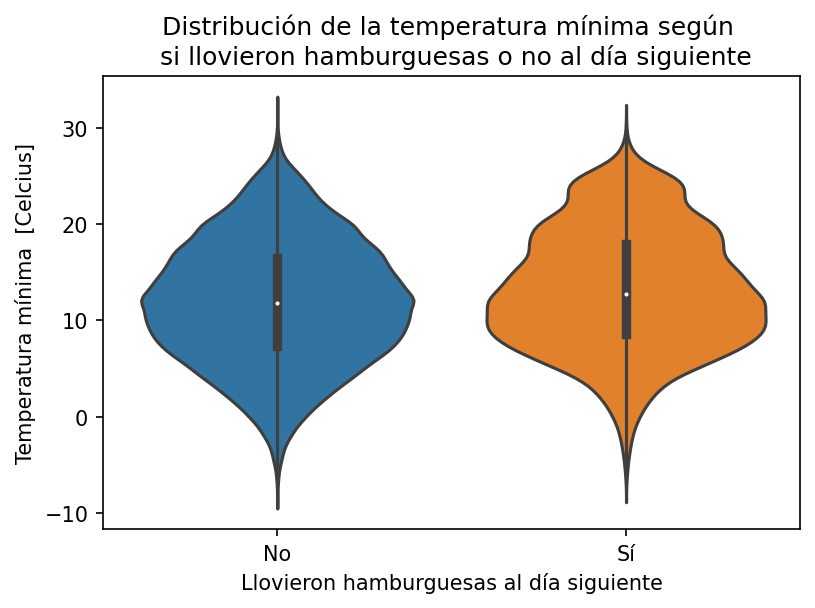

In [38]:
plt.figure(dpi=150)
plt.title("Distribución de la temperatura mínima según \n si llovieron hamburguesas o no al día siguiente")
sns.violinplot(
    data=df,
    y='temp_min',
    x='llovieron_hamburguesas_al_dia_siguiente'
#    palette=['#D17049', "#89D15E"],
)
plt.xlabel("Llovieron hamburguesas al día siguiente")
plt.ylabel("Temperatura mínima  [Celcius]")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Vemos que ni la temperatura máxima ni la mínima en el día parecen ser determinantes de si llueven o no hamburguesas al día siguiente. La forma del violin es prácticamente la misma se cumpla o no el target.

### 11. ¿Tiene relación la humedad con la variable target?
Para responder esta pregunta analitica, planteamos dos boxplots, uno para cada momento del dia

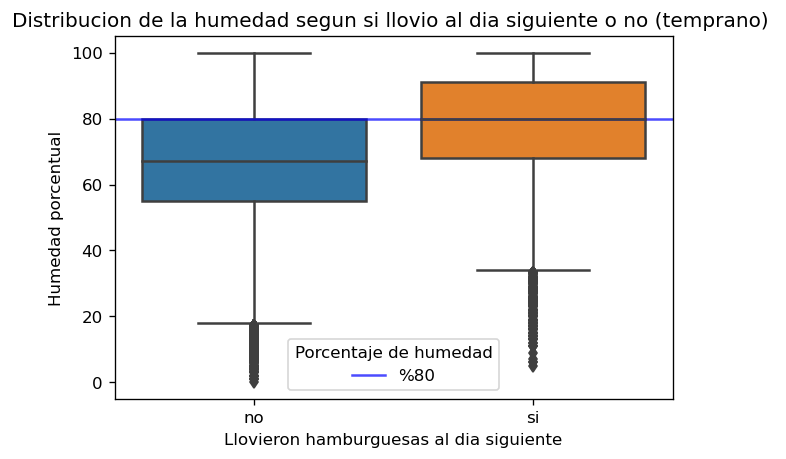

In [39]:
plt.figure(dpi=120)
plt.title("Distribucion de la humedad segun si llovio al dia siguiente o no (temprano) ")
sns.boxplot(
    data=df,
    y='humedad_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente'
)
plt.ylabel("Humedad porcentual")
plt.xlabel("Llovieron hamburguesas al dia siguiente")
plt.axhline(y=80, color="blue", label="%80", alpha=0.7)
plt.legend(title="Porcentaje de humedad")
plt.show()

No es observable una gran diferencia en cuanto a las distribuciones de humedad temprana. Se ve como dato notable que la mediana de humedad para cuando llueven hamburguesas al día siguiente esta donde termina el rango intercuartilico de la humedad para los dias que no llovieron hamburguesas, sin embargo no es un dato tan fuerte como para suponer afirmaciones en la baseline. Analizaremos la humedad a la tarde para ver si podemos concluir afirmaciones mas precisas.

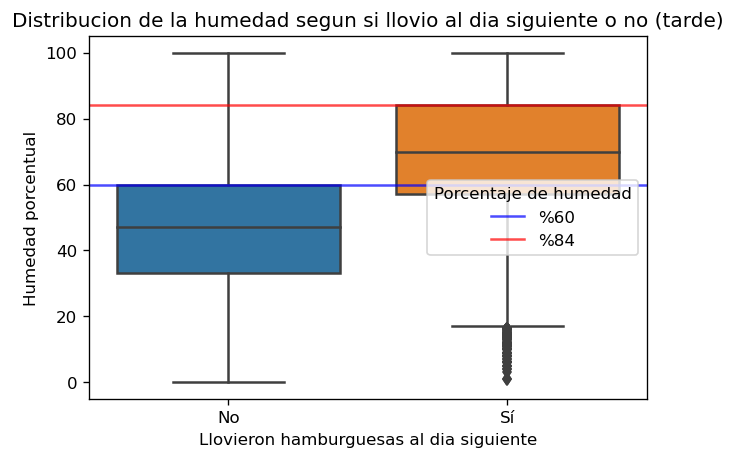

In [40]:
plt.figure(dpi=120)
plt.title("Distribucion de la humedad segun si llovio al dia siguiente o no (tarde)")
sns.boxplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente'
)
plt.ylabel("Humedad porcentual")
plt.xlabel("Llovieron hamburguesas al dia siguiente")
plt.axhline(y=60, color="blue", label="%60", alpha=0.7)
plt.axhline(y=84, color="red", label="%84", alpha=0.7)
plt.legend(title="Porcentaje de humedad")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

En este caso se ve una diferencia mucho mas clara, ya que donde termina el rango intercuartilico de los casos en los que no llueven hamburguesas al dia siguiente, 
esta proximo al inicio del rango intercuartilico de los casos en los que si llueven al día siguiente. Entonces podemos suponer que si la humedad a la tarde es aproximadamente mayor a 80%, es probable que al dia siguiente lluevan hamburguesas.

### 12. ¿Es observable una correlación entre la presión atmosférica y el target?

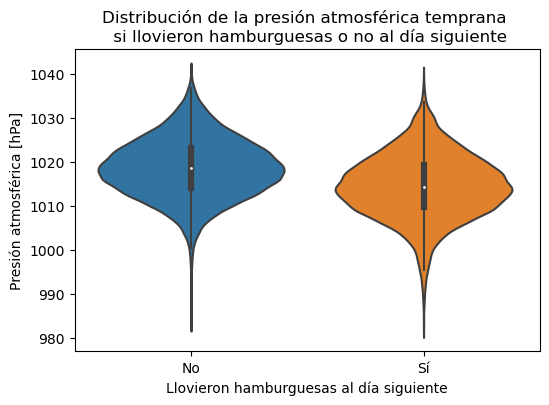

In [41]:
plt.figure(dpi=100)
plt.title("Distribución de la presión atmosférica temprana \n si llovieron hamburguesas o no al día siguiente")
sns.violinplot(
    data=df,
    y='presion_atmosferica_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente'
)
plt.xlabel("Llovieron hamburguesas al día siguiente")
plt.ylabel("Presión atmosférica [hPa]")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

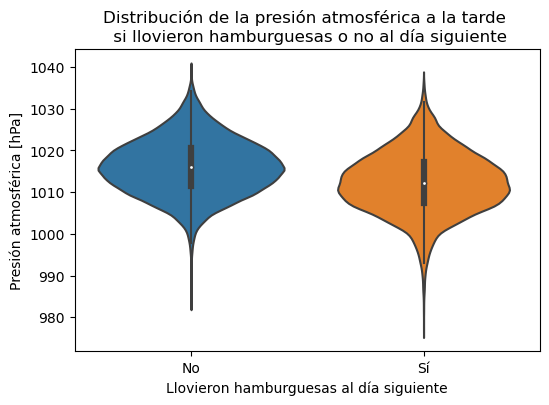

In [42]:
plt.figure(dpi=100)
plt.title("Distribución de la presión atmosférica a la tarde \n si llovieron hamburguesas o no al día siguiente")

df_aux = df.explode('presion_atmosferica_tarde')
df_aux['presion_atmosferica_tarde'] = df_aux['presion_atmosferica_tarde'].astype('float')

sns.violinplot(
    data=df_aux,
    y='presion_atmosferica_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente'
)
plt.xlabel("Llovieron hamburguesas al día siguiente")
plt.ylabel("Presión atmosférica [hPa]")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

### 13. ¿Son de utilidad las mediciones donde el target tiene el valor NaN?

Recordando como se ve a continuación, que el porcentaje de missings en la variable target es relativamente bajo, es válido plantearnos si seria conveniente droppear del dataset los registros que tengan un NaN en la variable target.

In [43]:
df_con_nulos = df_nulos[df_nulos['Cantidad de nulos'] > 0]
df_con_nulos.sort_values(by=['Porcentaje de nulos']).head()

,Cantidad de nulos,Porcentaje de nulos
humedad_temprano,2117,1.819229
velocidad_viendo_tarde,2444,2.100234
llovieron_hamburguesas_hoy,2615,2.247181
mm_lluvia_dia,2615,2.247181
llovieron_hamburguesas_al_dia_siguiente,2639,2.267806


Como podemos ver, llovieron_hamburguesas_al_dia_siguiente tiene missings en un ~2.3% de los registros del dataset, por lo que no sería a primera vista muy grave droppear aquellas mediciones con el target en NaN. Sin embargo, también es de importancia tener en cuenta que a la hora de predecir el target en nuestro algoritmo no tendremos con qué comparar la estimación de dicho algoritmo si la feature pertinente se encuentra en NaN. Esto nos resulta un importante indicativo de que terminaremos ignorando en el baseline las mediciones con missings en el target. 

Aun así, vamos a comparar para estar seguros las distribuciones de la feature humedad_tarde cuando el target está en NaN contra cuando no. Ya que humedad_tarde es la feature que nosotros consideramos con mejor potencial de predicción, si no tiene un cambio radical de comportamiento cuando el target tiene missings, entonces procederemos a droppear dichos registros.

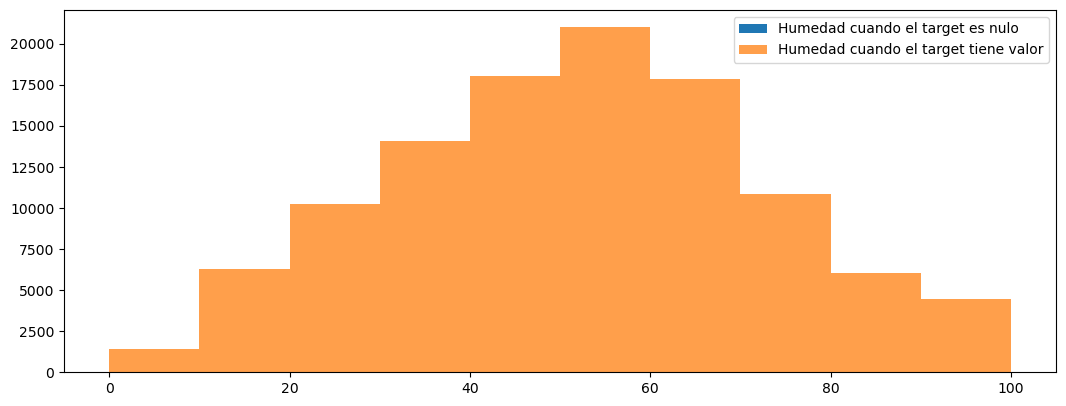

In [59]:
fig = plt.figure(figsize=[6.4 * 2, 4.8], dpi=100)

df_target_missings = df[df.llovieron_hamburguesas_al_dia_siguiente == np.nan]
df_target_completo = df[df.llovieron_hamburguesas_al_dia_siguiente != np.nan]

plt.hist(df_target_missings.humedad_tarde,   label='Humedad cuando el target es nulo')
plt.hist(df_target_completo.humedad_tarde, alpha=0.75, label='Humedad cuando el target tiene valor')

plt.legend()
plt.show()

Habiendo realizado este análisis, podemos tomar como criterio droppear aquellos registros donde el target es nulo.

# Conclusiones de la visualizacion y análisis:
 * La humedad de la tarde parece ser una buena indicadora de la variable target, siendo así que será considerada como feature principal de predicción dentro de nuestra baseline.
 * Las features horas de sol y de nubosidades, a pesar de tener una gran cantidad de missings, fueron destacadas ya que también discriminan de manera clara los casos en los que llueven hamburguesas al día siguiente de los que no.
 * La feature "llovieron_hamburguesas_hoy" también sera considerada para predecir el target ya que cuando su valor es 'si', la probabilidad de que llovieron_hamburguesas_al_dia_siguiente sea positiva aumenta drásticamente con respecto a cuando no.
 * Hay una gran cantidad de features de las cuales no pudimos sacar conclusiones que nos ayuden a predecir el valor de la variable target ya que poseian una distribución equitativa en todos sus valores posibles, para ambos valores del target.

# Baselines posibles
### Comencemos por definir una serie de baselines posibles según nuestro análisis previo, con el objetivo de intentar predecir la variable target.

#### Para esto primero crearemos una función de preprocesamiento, la cuál se encargará de:
    1. Droppear del dataset los registros que tengan un NaN en la variable target, por lo cual no podemos saber si nuestra predicción está bien o no, ni aprender nada de ellos.
    2. Droppear del dataset las filas que tengan todos los siguientes registros en null: humedad_tarde, horas_de_sol, nubosidad_tarde. Esto se debe a que son los más indicativos que vimos durante el análisis y necesitaremos de ellos para formar el baseline.
    3. Droppear del dataset los registros que tengan alrededor de la mitad de campos en NaN, los cuales consideramos mediciones de poca calidad e incompletas.

In [45]:
def preprocesar_df(df_raw:pd.DataFrame):
    df_raw = df_raw.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])
    df_raw = df_raw.dropna(subset=['humedad_tarde', 'horas_de_sol', 'nubosidad_tarde'], how='all')
    df_raw = df_raw.dropna(thresh = len(df_raw.columns) - 10)
    return df_raw

#### Una vez definida la función de preprocesamiento, programamos una serie de diferentes baselines que intuimos superaran el 80% de accuracy al predecir el target:

In [46]:
def baseline(df_baseline:pd.DataFrame):
    
    llovio_h_hoy = (df_baseline['llovieron_hamburguesas_hoy'] == 'si')
    
    alta_humedad_tarde = (df_baseline['humedad_tarde'] >= 79)
    horas_sol_bajas = (df_baseline['horas_de_sol'] <= 7.5)
    alta_nubosidad_tarde = (df_baseline['nubosidad_tarde'] >= 7.1)
    
    df_baseline['prediccion_llueven_h_al_dia_siguiente'] = 'no'
    df.loc[alta_humedad_tarde, 'prediccion_llueven_h_al_dia_siguiente'] = 'si'
    df.loc[llovio_h_hoy & alta_nubosidad_tarde & horas_sol_bajas, 'prediccion_llueven_h_al_dia_siguiente'] = 'si'
    
    resultado =  df_baseline['prediccion_llueven_h_al_dia_siguiente'].values.tolist()
    df_baseline.drop(columns=['prediccion_llueven_h_al_dia_siguiente']) #remuevo la columna de predicciones para no alterar el df original
    return resultado

def baseline_2(df_baseline:pd.DataFrame):
    
    alta_humedad_tarde = (df_baseline['humedad_tarde'] >= 79)
    
    df_baseline['prediccion_llueven_h_al_dia_siguiente'] = 'no'
    df.loc[alta_humedad_tarde, 'prediccion_llueven_h_al_dia_siguiente'] = 'si'
    
    resultado =  df_baseline['prediccion_llueven_h_al_dia_siguiente'].values.tolist()
    df_baseline.drop(columns=['prediccion_llueven_h_al_dia_siguiente'])
    return resultado

def baseline_3(df_baseline:pd.DataFrame):
    
    llovio_h_hoy = (df_baseline['llovieron_hamburguesas_hoy'] == 'si')
    alta_humedad_tarde = (df_baseline['humedad_tarde'] >= 79)
    alta_nubosidad_tarde = (df_baseline['nubosidad_tarde'] >= 7.1)

    df_baseline['prediccion_llueven_h_al_dia_siguiente'] = 'no'
    df.loc[alta_humedad_tarde, 'prediccion_llueven_h_al_dia_siguiente'] = 'si'
    df.loc[llovio_h_hoy & alta_nubosidad_tarde , 'prediccion_llueven_h_al_dia_siguiente'] = 'si'
    
    resultado =  df_baseline['prediccion_llueven_h_al_dia_siguiente'].values.tolist()
    df_baseline.drop(columns=['prediccion_llueven_h_al_dia_siguiente']) #remuevo la columna de predicciones para no alterar el df original
    return resultado






# Predicción según baselines
### Pasamos entonces a probar las funciones baselines definidas y a comparar las accuracies resultantes:

Para el primer baseline, que tiene en cuenta principalmente la feature humedad_tarde, y luego también predice que llueve al dia siguiente para aquellas filas donde haya alta nubosidad a la tarde, bajas horas de sol, y haya llovido hamburguesas hoy, la accuracy resulta:

In [47]:
df = preprocesar_df(df_original)
(baseline(df) == df['llovieron_hamburguesas_al_dia_siguiente']).mean().round(4)

0.8261

Para el segundo baseline, que se guia únicamente en si hubo una alta humedad a la tarde o no, la accuracy resulta:

In [48]:
df = preprocesar_df(df_original)
(baseline_2(df) == df['llovieron_hamburguesas_al_dia_siguiente']).mean().round(4)

0.8255

Finalmente nuestro tercer baseline es muy parecido al primero, con la diferencia de ignorar las horas de sol:

In [49]:
df = preprocesar_df(df_original)
(baseline_3(df) == df['llovieron_hamburguesas_al_dia_siguiente']).mean().round(4)

0.8242

### Se observa que en caso de tener que elegir entre nuestros baselines, aquel con un puntaje de accuracy más elevado, entonces se utilizaría el primero. Sin embargo consideramos de alta importancia notar que el segundo baseline es solamente un 0,1% menos preciso, siendo a su vez más simple por necesitar solamente de la feature humedad_tarde para predecir.